In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

from copy import deepcopy
import logging
import math
from matplotlib.cm import get_cmap, ScalarMappable
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
import os
import pandas as pd
import scipy
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import r2_score
import sys

sys.path.append('../../')
from data_utils import *

sys.path.append('../../../DeLASE')
from delase import *
from stability_estimation import *
from parameter_choosing import *
from performance_metrics import *

plt.style.use('../../sci_style.py')

# Load Neural Data

In [3]:
session = 'Lucky-08032018'

session_data = dict(
    preOddball=dict(
        session_name = '-'.join([session.split('-')[0], 'preOddball', session.split('-')[1], '001'])
    ),
    Anesthesia=dict(
        session_name = '-'.join([session.split('-')[0], 'Anesthesia', session.split('-')[1], '002'])
    ),
    postOddball=dict(
        session_name = '-'.join([session.split('-')[0], 'postOddball', session.split('-')[1], '001'])
    )
)

In [11]:
all_data_dir = '/millerdata/data/common/datasets/anesthesia/mat'
for section in tqdm(session_data.keys(), total=len(session_data.keys())):
    section_session = session_data[section]['session_name']
    data_class = get_data_class(section_session, all_data_dir)
    
    os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"
    variables = ['electrodeInfo', 'lfp', 'lfpSchema', 'sessionInfo', 'trialInfo', 'unitInfo']
    session_vars, T, N, dt = load_session_data(section_session, all_data_dir, variables, data_class=data_class, verbose=False)
    electrode_info, lfp, lfp_schema, session_info, trial_info, unit_info = session_vars['electrodeInfo'], session_vars['lfp'], session_vars['lfpSchema'], session_vars['sessionInfo'], session_vars['trialInfo'], session_vars['unitInfo']
    vars_dict = dict(
        electrode_info=electrode_info,
        lfp=lfp,
        lfp_schema=lfp_schema,
        session_info=session_info,
        trial_info=trial_info,
        unit_info=unit_info,
        tone_on = [a[0] for a in trial_info['odd_toneOn']]
    )
    session_data[section] = session_data[section] | vars_dict

  0%|          | 0/3 [00:00<?, ?it/s]

# Trajectories

In [140]:
leadup = 2500
post = 2500

In [141]:
def calc_row_idx(k, n):
    return int(math.ceil((1/2.) * (- (-8*k + 4 *n**2 -4*n - 7)**0.5 + 2*n -1) - 1))

def elem_in_i_rows(i, n):
    return i * (n - 1 - i) + (i*(i + 1))//2

def calc_col_idx(k, i, n):
    return int(n - elem_in_i_rows(i + 1, n) + k)

def condensed_to_square(k, n):
    i = calc_row_idx(k, n)
    j = calc_col_idx(k, i, n)
    return i, j

In [142]:
for section in session_data.keys():
    lfp_tone = []
    for t in session_data[section]['tone_on']:
        t = int(t/dt)
        if t - leadup > 0 and t + post < session_data[section]['lfp'].shape[0]:
            lfp_tone.append(session_data[section]['lfp'][t - leadup:t + post])
    lfp_tone = np.array(lfp_tone)
    session_data[section]['lfp_tone'] = lfp_tone

In [143]:
lfp_tone_wake = session_data['preOddball']['lfp_tone']
lfp_tone_anesthesia = session_data['Anesthesia']['lfp_tone']

In [144]:
areas = np.hstack([np.unique(session_data['Anesthesia']['electrode_info']['area']), ['all']])

n_wake = 480, n_anesthesia = 480


  0%|          | 0/114960 [00:00<?, ?it/s]

  0%|          | 0/114960 [00:00<?, ?it/s]

n_wake = 480, n_anesthesia = 480


  0%|          | 0/114960 [00:00<?, ?it/s]

  0%|          | 0/114960 [00:00<?, ?it/s]

n_wake = 480, n_anesthesia = 480


  0%|          | 0/114960 [00:00<?, ?it/s]

  0%|          | 0/114960 [00:00<?, ?it/s]

n_wake = 480, n_anesthesia = 480


  0%|          | 0/114960 [00:00<?, ?it/s]

  0%|          | 0/114960 [00:00<?, ?it/s]

n_wake = 480, n_anesthesia = 480


  0%|          | 0/114960 [00:00<?, ?it/s]

  0%|          | 0/114960 [00:00<?, ?it/s]

n_wake = 480, n_anesthesia = 480


  0%|          | 0/114960 [00:00<?, ?it/s]

  0%|          | 0/114960 [00:00<?, ?it/s]

n_wake = 480, n_anesthesia = 480


  0%|          | 0/114960 [00:00<?, ?it/s]

  0%|          | 0/114960 [00:00<?, ?it/s]

n_wake = 480, n_anesthesia = 480


  0%|          | 0/114960 [00:00<?, ?it/s]

  0%|          | 0/114960 [00:00<?, ?it/s]

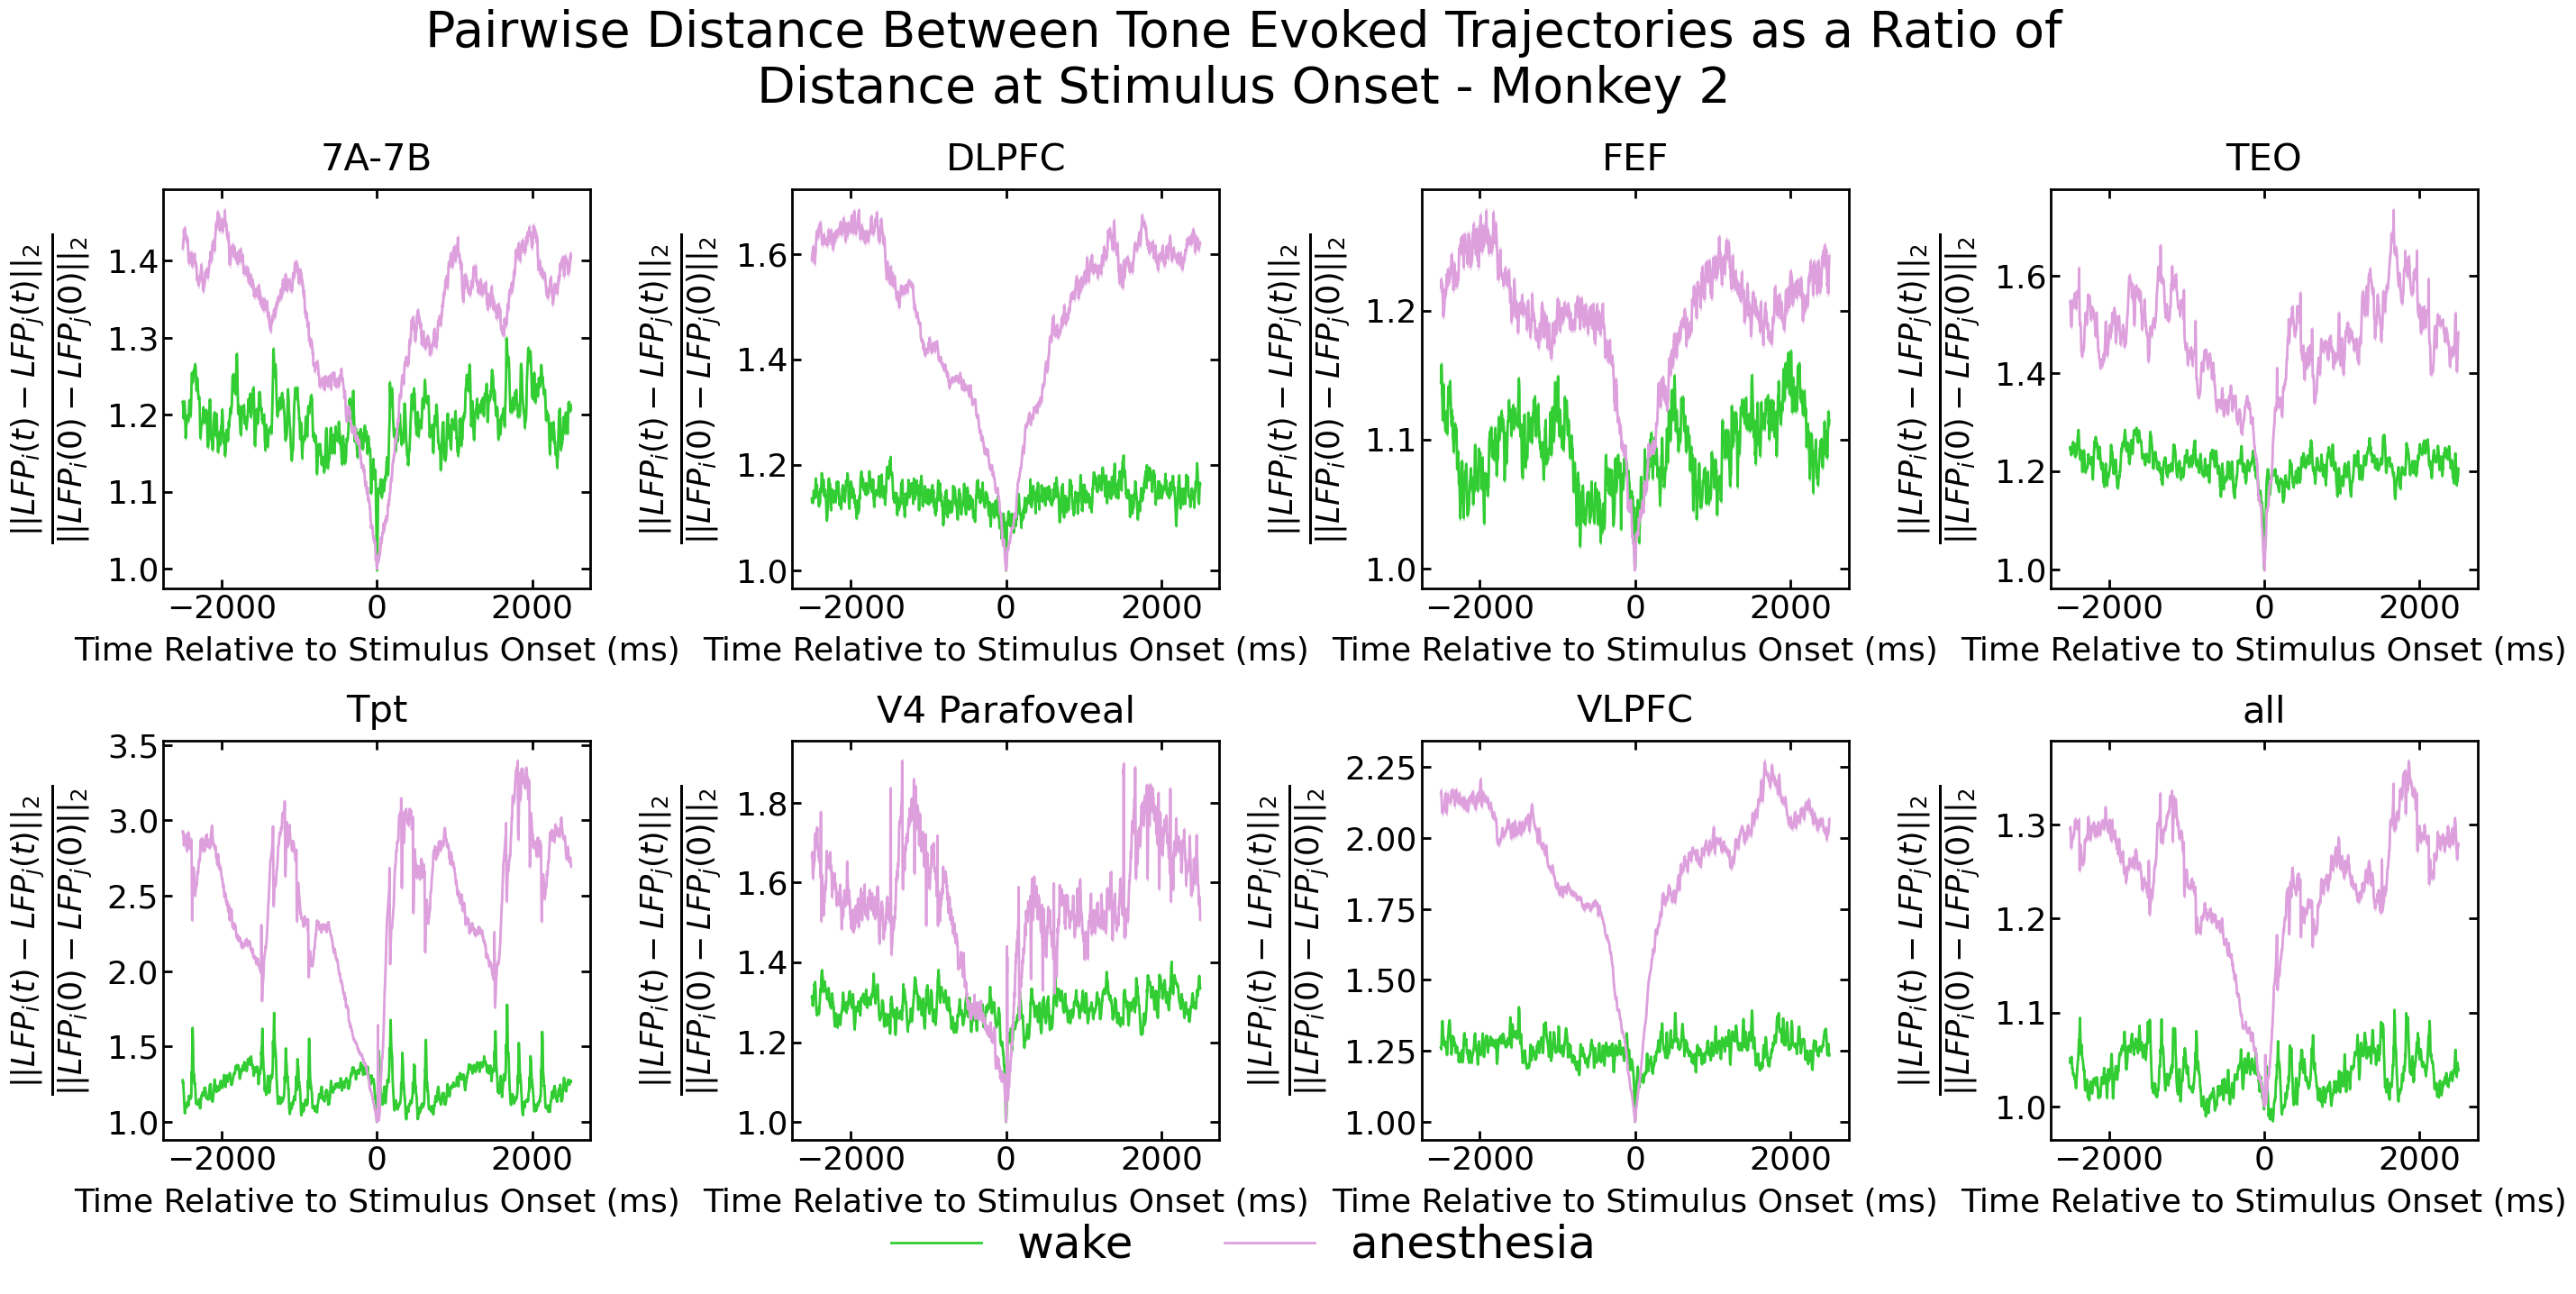

In [145]:
fig = plt.figure(figsize=(28, 14))
# for i, area in enumerate(['vlPFC', 'FEF', '7b', 'CPB']):

# for i, area in enumerate(['vlPFC']):
for i, area in enumerate(areas):
    plt.subplot(2, 4, i + 1)
    if area == 'all':
        unit_indices = np.arange(len(electrode_info['area']))
    else:
        unit_indices = np.where(electrode_info['area'] == area)[0]
    
#     NO PCA
    lfp_tone_wake_embed = lfp_tone_wake[:, :, unit_indices]
    lfp_tone_anesthesia_embed = lfp_tone_anesthesia[:, :, unit_indices]

#     # FIT PCA TO INDIVIDUAL TRAJECTORIES
#     n_components = 3
#     manifold_embed = PCA(n_components=n_components)
#     # manifold_embed = Isomap(n_components=3)
#     lfp_tone_wake_embed = np.zeros((lfp_tone_wake.shape[0], lfp_tone_wake.shape[1], n_components))
#     for i in tqdm(range(lfp_tone_wake.shape[0])):
#         lfp_tone_wake_embed[i] = manifold_embed.fit_transform(lfp_tone_wake[i])

#     lfp_tone_anesthesia_embed = np.zeros((lfp_tone_anesthesia.shape[0], lfp_tone_wake.shape[1], n_components))
#     for i in tqdm(range(lfp_tone_anesthesia.shape[0])):
#         lfp_tone_anesthesia_embed[i] = manifold_embed.fit_transform(lfp_tone_anesthesia[i])

    # FIT PCA TO THE MEAN TRAJECTORY
#     pca = PCA(n_components=3).fit(lfp_tone_wake.mean(axis=0))
#     lfp_tone_wake_embed = np.array([pca.transform(lfp_tone_wake[i]) for i in range(lfp_tone_wake.shape[0])])

#     pca = PCA(n_components=3).fit(lfp_tone_anesthesia.mean(axis=0))
#     lfp_tone_anesthesia_embed = np.array([pca.transform(lfp_tone_anesthesia[i]) for i in range(lfp_tone_anesthesia.shape[0])])

#     # interior normalization
    lfp_tone_wake_embed = (lfp_tone_wake_embed - lfp_tone_wake_embed.mean(axis=(0, 1)))/lfp_tone_wake_embed.std(axis=(0,1))
    lfp_tone_anesthesia_embed = (lfp_tone_anesthesia_embed - lfp_tone_anesthesia_embed.mean(axis=(0,1)))/lfp_tone_anesthesia_embed.std(axis=(0,1))

    n_wake = lfp_tone_wake_embed.shape[0]
    n_anesthesia = lfp_tone_anesthesia_embed.shape[0]
    print(f"n_wake = {n_wake}, n_anesthesia = {n_anesthesia}")
#     num_min_inds = np.min([n_wake, n_anesthesia])
    num_min_inds = np.min([int(n_wake*(n_wake + 1)/2 - n_wake), int(n_anesthesia*(n_anesthesia + 1)/2 - n_anesthesia)])
#     num_min_inds = np.max([n_wake, n_anesthesia])
#     num_min_inds = 500
    
#     num_min_inds = n_wake
    dist_wake_multi = np.zeros((num_min_inds, leadup + post))
    pdist_argsort = pdist(lfp_tone_wake_embed[:, leadup]).argsort()
    for min_ind in tqdm(range(num_min_inds)):
        ind = pdist_argsort[min_ind]
        traj_inds = condensed_to_square(ind, lfp_tone_wake_embed.shape[0])
        dist_wake = np.linalg.norm(lfp_tone_wake_embed[traj_inds[0]] - lfp_tone_wake_embed[traj_inds[1]], axis=1)
        ratio = dist_wake[leadup]
        dist_wake_multi[min_ind] = dist_wake/ratio
#         dist_wake_multi[min_ind] = dist_wake

#     num_min_inds = n_anesthesia
    dist_anesthesia_multi = np.zeros((num_min_inds, leadup + post))
    pdist_argsort = pdist(lfp_tone_anesthesia_embed[:, leadup]).argsort()
    for min_ind in tqdm(range(num_min_inds)):
        ind = pdist_argsort[min_ind]
        traj_inds = condensed_to_square(ind, lfp_tone_anesthesia_embed.shape[0])
        dist_anesthesia = np.linalg.norm(lfp_tone_anesthesia_embed[traj_inds[0]] - lfp_tone_anesthesia_embed[traj_inds[1]], axis=1)
        ratio = dist_anesthesia[leadup]
        dist_anesthesia_multi[min_ind] = dist_anesthesia/ratio
#         dist_anesthesia_multi[min_ind] = dist_anesthesia
    
#     # standardize
#     dist_wake_multi = (dist_wake_multi - dist_wake_multi.mean(axis=1).reshape(-1, 1))/dist_wake_multi.std(axis=1).reshape(-1, 1)
#     dist_anesthesia_multi = (dist_anesthesia_multi - dist_anesthesia_multi.mean(axis=1).reshape(-1, 1))/dist_anesthesia_multi.std(axis=1).reshape(-1, 1)

#     plt.title(f"{area_labels[area]}", fontsize=40)

    # ratio = 1
    mean_dist_wake = dist_wake_multi.mean(axis=0)
    se_dist_wake = dist_wake_multi.std(axis=0)/np.sqrt(dist_wake_multi.shape[0])
    lns = []
    lns += plt.plot(np.arange(-leadup, post), mean_dist_wake, c='limegreen', label='wake')
    plt.fill_between(np.arange(-leadup, post), mean_dist_wake - se_dist_wake, mean_dist_wake + se_dist_wake, color='limegreen', alpha=0.4)

    mean_dist_anesthesia = dist_anesthesia_multi.mean(axis=0)
    se_dist_anesthesia = dist_anesthesia_multi.std(axis=0)/np.sqrt(dist_anesthesia_multi.shape[0])
    lns += plt.plot(np.arange(-leadup, post), mean_dist_anesthesia, c='plum', label='anesthesia')
    plt.fill_between(np.arange(-leadup, post), mean_dist_anesthesia - se_dist_anesthesia, mean_dist_anesthesia + se_dist_anesthesia, color='plum', alpha=0.4)
    plt.xlabel('Time Relative to Stimulus Onset (ms)', fontsize=26)
#     plt.legend()
    plt.ylabel(r"$\frac{||LFP_i(t) - LFP_j(t)||_2}{||LFP_i(0) - LFP_j(0)||_2}$", fontsize=36)
    ax = plt.gca()
    ax.tick_params(axis='both', which='major', labelsize=26)
    ax.tick_params(axis='both', which='minor', labelsize=26)
    ax.set_title(area, fontsize=30)
plt.suptitle(f"Pairwise Distance Between Tone Evoked Trajectories as a Ratio of\nDistance at Stimulus Onset - Monkey {1 if 'Mary' in session else 2}", fontsize=40)
fig.legend(lns, [ln.get_label() for ln in lns], fontsize=36, ncol=2, bbox_to_anchor=(0.5, 0), loc='center')
plt.tight_layout()
plt.show()

In [131]:
wake_ts = np.random.uniform(leadup, session_data['preOddball']['lfp'].shape[0] - post, size=(n_wake,))
anesthesia_ts = np.random.uniform(leadup, session_data['Anesthesia']['lfp'].shape[0] - post, size=(n_anesthesia,))

In [132]:
lfp_tone_wake = []
for t in wake_ts:
    lfp_tone_wake.append(session_data['preOddball']['lfp'][int(t) - leadup:int(t) + post])
lfp_tone_wake = np.array(lfp_tone_wake)

In [133]:
lfp_tone_anesthesia = []
for t in anesthesia_ts:
    lfp_tone_anesthesia.append(session_data['Anesthesia']['lfp'][int(t) - leadup:int(t) + post])
lfp_tone_anesthesia = np.array(lfp_tone_anesthesia)

n_wake = 480, n_anesthesia = 480


  0%|          | 0/114960 [00:00<?, ?it/s]

  0%|          | 0/114960 [00:00<?, ?it/s]

n_wake = 480, n_anesthesia = 480


  0%|          | 0/114960 [00:00<?, ?it/s]

  0%|          | 0/114960 [00:00<?, ?it/s]

n_wake = 480, n_anesthesia = 480


  0%|          | 0/114960 [00:00<?, ?it/s]

  0%|          | 0/114960 [00:00<?, ?it/s]

n_wake = 480, n_anesthesia = 480


  0%|          | 0/114960 [00:00<?, ?it/s]

  0%|          | 0/114960 [00:00<?, ?it/s]

n_wake = 480, n_anesthesia = 480


  0%|          | 0/114960 [00:00<?, ?it/s]

  0%|          | 0/114960 [00:00<?, ?it/s]

n_wake = 480, n_anesthesia = 480


  0%|          | 0/114960 [00:00<?, ?it/s]

  0%|          | 0/114960 [00:00<?, ?it/s]

n_wake = 480, n_anesthesia = 480


  0%|          | 0/114960 [00:00<?, ?it/s]

  0%|          | 0/114960 [00:00<?, ?it/s]

n_wake = 480, n_anesthesia = 480


  0%|          | 0/114960 [00:00<?, ?it/s]

  0%|          | 0/114960 [00:00<?, ?it/s]

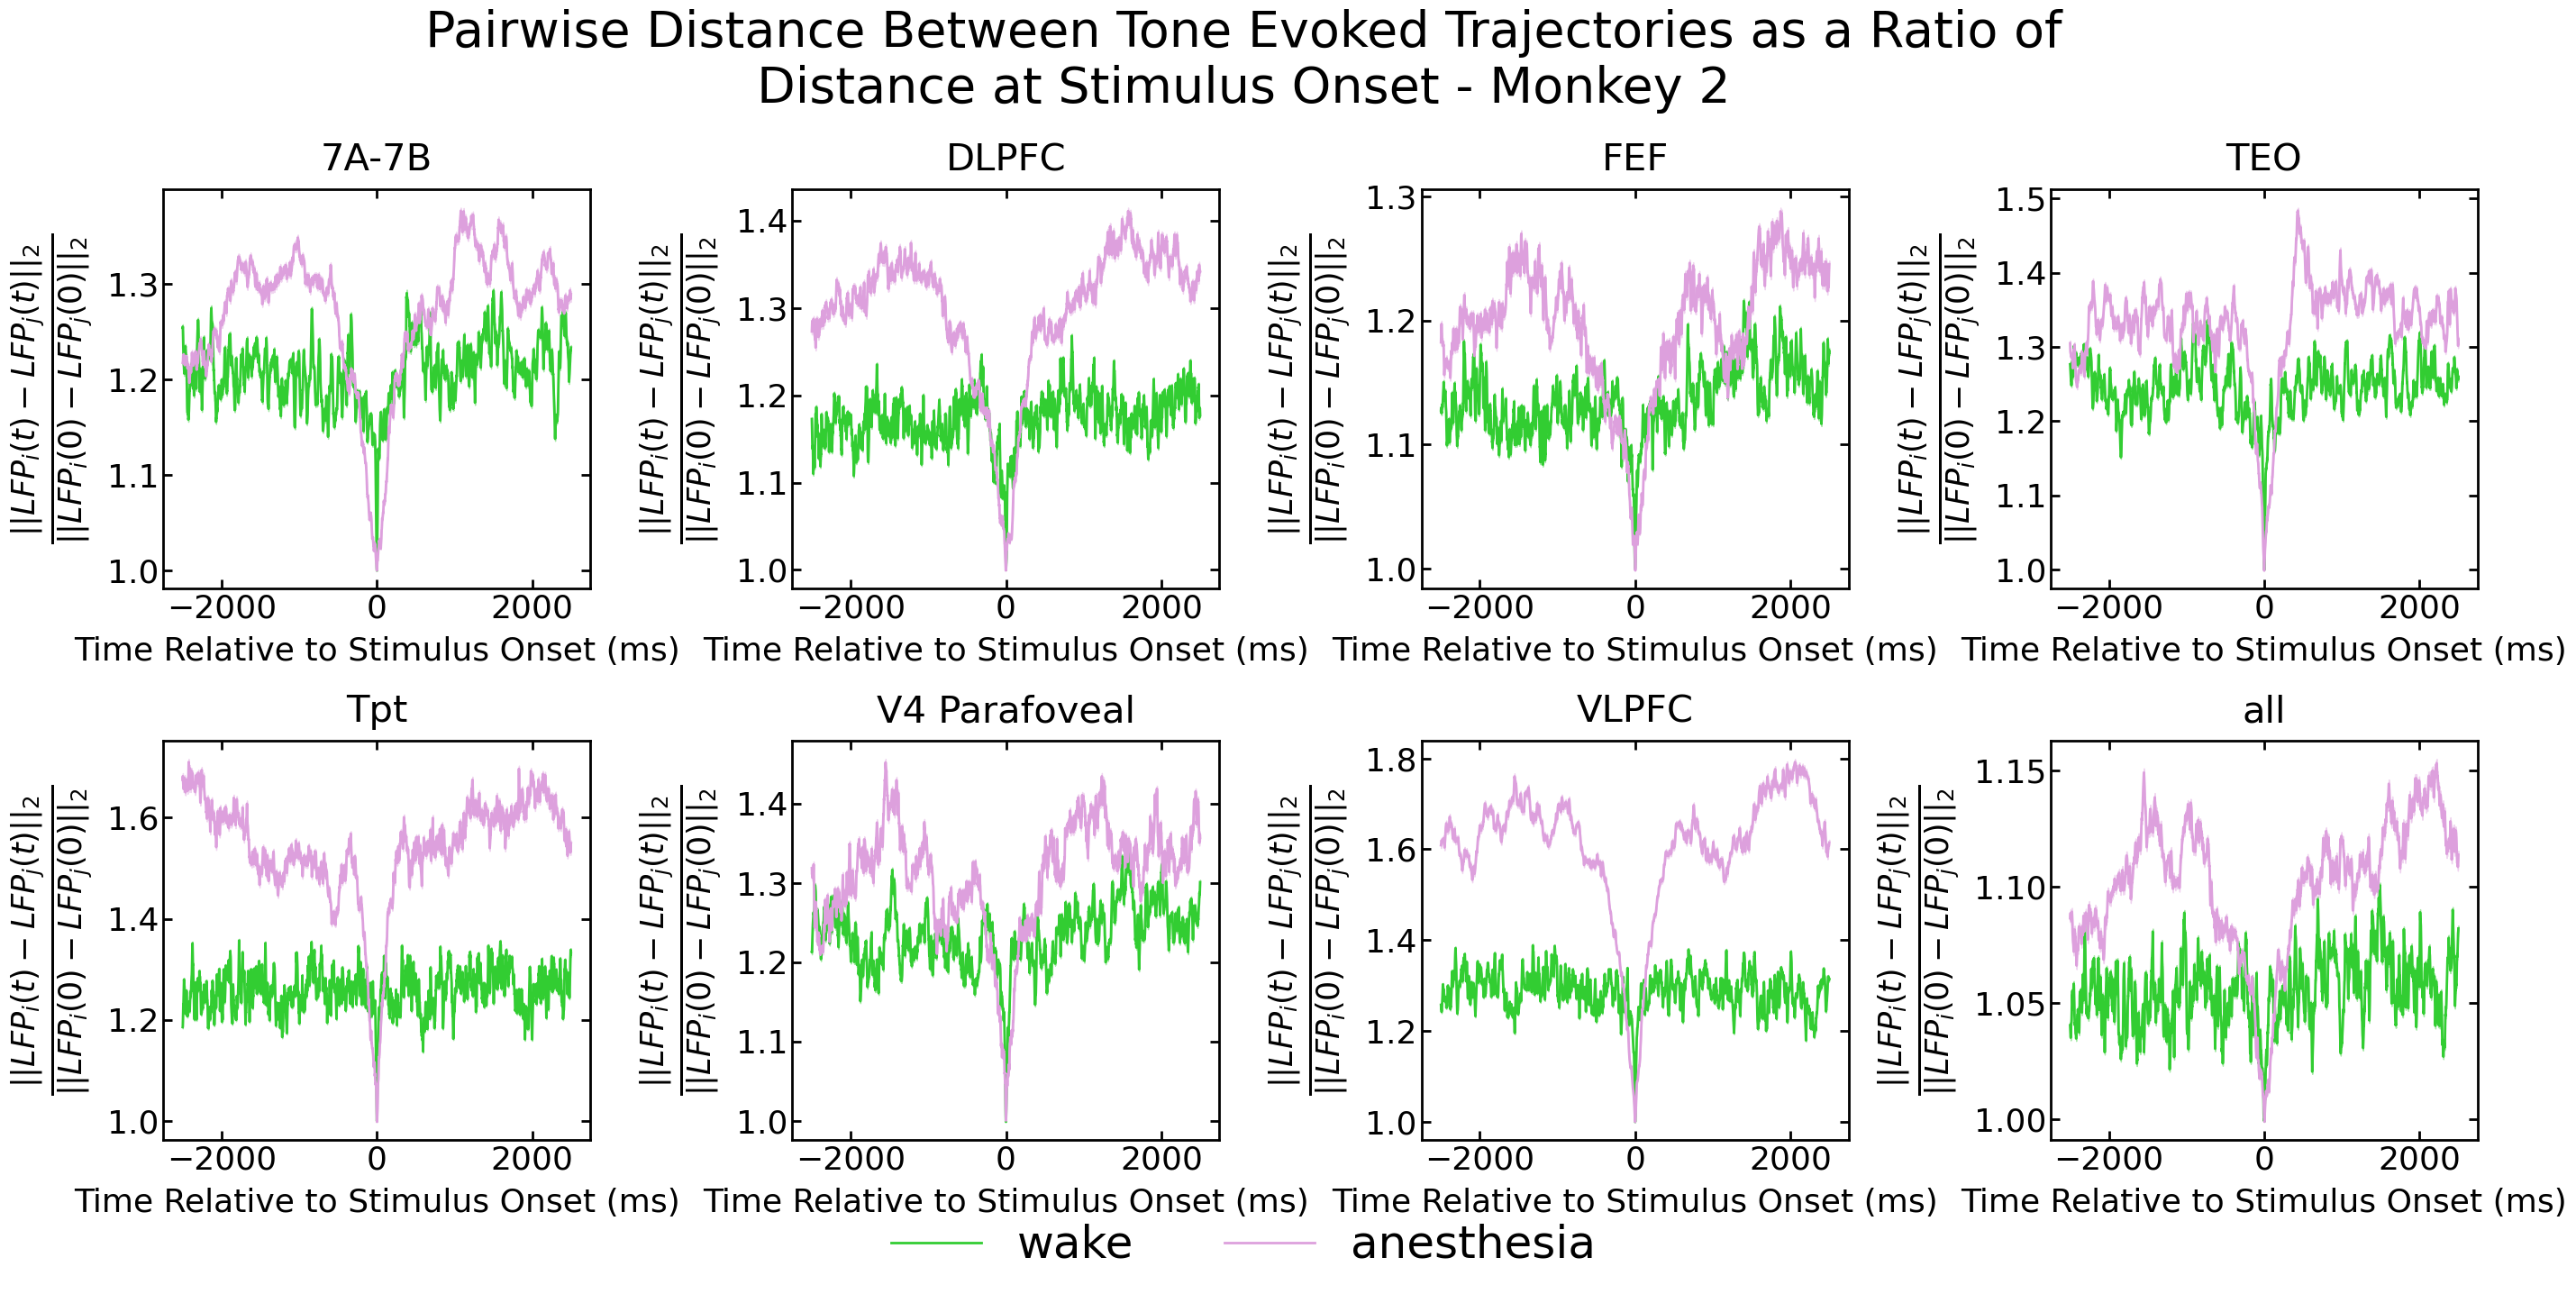

In [138]:
fig = plt.figure(figsize=(28, 14))
# for i, area in enumerate(['vlPFC', 'FEF', '7b', 'CPB']):

# for i, area in enumerate(['vlPFC']):
for i, area in enumerate(areas):
    plt.subplot(2, 4, i + 1)
    if area == 'all':
        unit_indices = np.arange(len(electrode_info['area']))
    else:
        unit_indices = np.where(electrode_info['area'] == area)[0]
    
#     NO PCA
    lfp_tone_wake_embed = lfp_tone_wake[:, :, unit_indices]
    lfp_tone_anesthesia_embed = lfp_tone_anesthesia[:, :, unit_indices]

#     # FIT PCA TO INDIVIDUAL TRAJECTORIES
#     n_components = 3
#     manifold_embed = PCA(n_components=n_components)
#     # manifold_embed = Isomap(n_components=3)
#     lfp_tone_wake_embed = np.zeros((lfp_tone_wake.shape[0], lfp_tone_wake.shape[1], n_components))
#     for i in tqdm(range(lfp_tone_wake.shape[0])):
#         lfp_tone_wake_embed[i] = manifold_embed.fit_transform(lfp_tone_wake[i])

#     lfp_tone_anesthesia_embed = np.zeros((lfp_tone_anesthesia.shape[0], lfp_tone_wake.shape[1], n_components))
#     for i in tqdm(range(lfp_tone_anesthesia.shape[0])):
#         lfp_tone_anesthesia_embed[i] = manifold_embed.fit_transform(lfp_tone_anesthesia[i])

    # FIT PCA TO THE MEAN TRAJECTORY
#     pca = PCA(n_components=3).fit(lfp_tone_wake.mean(axis=0))
#     lfp_tone_wake_embed = np.array([pca.transform(lfp_tone_wake[i]) for i in range(lfp_tone_wake.shape[0])])

#     pca = PCA(n_components=3).fit(lfp_tone_anesthesia.mean(axis=0))
#     lfp_tone_anesthesia_embed = np.array([pca.transform(lfp_tone_anesthesia[i]) for i in range(lfp_tone_anesthesia.shape[0])])

#     # interior normalization
    lfp_tone_wake_embed = (lfp_tone_wake_embed - lfp_tone_wake_embed.mean(axis=(0, 1)))/lfp_tone_wake_embed.std(axis=(0,1))
    lfp_tone_anesthesia_embed = (lfp_tone_anesthesia_embed - lfp_tone_anesthesia_embed.mean(axis=(0,1)))/lfp_tone_anesthesia_embed.std(axis=(0,1))

    n_wake = lfp_tone_wake_embed.shape[0]
    n_anesthesia = lfp_tone_anesthesia_embed.shape[0]
    print(f"n_wake = {n_wake}, n_anesthesia = {n_anesthesia}")
#     num_min_inds = np.min([n_wake, n_anesthesia])
    num_min_inds = np.min([int(n_wake*(n_wake + 1)/2 - n_wake), int(n_anesthesia*(n_anesthesia + 1)/2 - n_anesthesia)])
#     num_min_inds = np.max([n_wake, n_anesthesia])
#     num_min_inds = 500
    
#     num_min_inds = n_wake
    dist_wake_multi = np.zeros((num_min_inds, leadup + post))
    pdist_argsort = pdist(lfp_tone_wake_embed[:, leadup]).argsort()
    for min_ind in tqdm(range(num_min_inds)):
        ind = pdist_argsort[min_ind]
        traj_inds = condensed_to_square(ind, lfp_tone_wake_embed.shape[0])
        dist_wake = np.linalg.norm(lfp_tone_wake_embed[traj_inds[0]] - lfp_tone_wake_embed[traj_inds[1]], axis=1)
        ratio = dist_wake[leadup]
        dist_wake_multi[min_ind] = dist_wake/ratio
#         dist_wake_multi[min_ind] = dist_wake

#     num_min_inds = n_anesthesia
    dist_anesthesia_multi = np.zeros((num_min_inds, leadup + post))
    pdist_argsort = pdist(lfp_tone_anesthesia_embed[:, leadup]).argsort()
    for min_ind in tqdm(range(num_min_inds)):
        ind = pdist_argsort[min_ind]
        traj_inds = condensed_to_square(ind, lfp_tone_anesthesia_embed.shape[0])
        dist_anesthesia = np.linalg.norm(lfp_tone_anesthesia_embed[traj_inds[0]] - lfp_tone_anesthesia_embed[traj_inds[1]], axis=1)
        ratio = dist_anesthesia[leadup]
        dist_anesthesia_multi[min_ind] = dist_anesthesia/ratio
#         dist_anesthesia_multi[min_ind] = dist_anesthesia
    
#     # standardize
#     dist_wake_multi = (dist_wake_multi - dist_wake_multi.mean(axis=1).reshape(-1, 1))/dist_wake_multi.std(axis=1).reshape(-1, 1)
#     dist_anesthesia_multi = (dist_anesthesia_multi - dist_anesthesia_multi.mean(axis=1).reshape(-1, 1))/dist_anesthesia_multi.std(axis=1).reshape(-1, 1)

#     plt.title(f"{area_labels[area]}", fontsize=40)

    # ratio = 1
    mean_dist_wake = dist_wake_multi.mean(axis=0)
    se_dist_wake = dist_wake_multi.std(axis=0)/np.sqrt(dist_wake_multi.shape[0])
    lns = []
    lns += plt.plot(np.arange(-leadup, post), mean_dist_wake, c='limegreen', label='wake')
    plt.fill_between(np.arange(-leadup, post), mean_dist_wake - se_dist_wake, mean_dist_wake + se_dist_wake, color='limegreen', alpha=0.4)

    mean_dist_anesthesia = dist_anesthesia_multi.mean(axis=0)
    se_dist_anesthesia = dist_anesthesia_multi.std(axis=0)/np.sqrt(dist_anesthesia_multi.shape[0])
    lns += plt.plot(np.arange(-leadup, post), mean_dist_anesthesia, c='plum', label='anesthesia')
    plt.fill_between(np.arange(-leadup, post), mean_dist_anesthesia - se_dist_anesthesia, mean_dist_anesthesia + se_dist_anesthesia, color='plum', alpha=0.4)
    plt.xlabel('Time Relative to Stimulus Onset (ms)', fontsize=26)
#     plt.legend()
    plt.ylabel(r"$\frac{||LFP_i(t) - LFP_j(t)||_2}{||LFP_i(0) - LFP_j(0)||_2}$", fontsize=36)
    ax = plt.gca()
    ax.tick_params(axis='both', which='major', labelsize=26)
    ax.tick_params(axis='both', which='minor', labelsize=26)
    ax.set_title(area, fontsize=30)
plt.suptitle(f"Pairwise Distance Between Randomly Centered Trajectories as a Ratio of\nDistance at Stimulus Onset - Monkey {1 if 'Mary' in session else 2}", fontsize=40)
fig.legend(lns, [ln.get_label() for ln in lns], fontsize=36, ncol=2, bbox_to_anchor=(0.5, 0), loc='center')
plt.tight_layout()
plt.show()